# Predict the electrical price

## 1. Libraries

In [2]:
!pip install dython

In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from dython.nominal import identify_nominal_columns
from dython.nominal import associations


## 2. Loading data to dataframe

In [112]:
energy_dataframe = pd.read_csv('energy_dataset.csv')
pd.set_option('display.max_columns', None)
print(energy_dataframe.shape)
energy_dataframe.head()

(35064, 29)


,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,920.0,1009.0,1658.0,0.0,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,1164.0,973.0,1371.0,0.0,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,1503.0,949.0,779.0,0.0,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,1826.0,953.0,720.0,0.0,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [113]:
weather_cities = pd.read_csv('weather_features.csv')
print(weather_cities.shape)
weather_cities.head()

(178396, 17)


,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


## 3. Check for null, 0, Nan, duplicate values in both dataframes

In [114]:
energy_dataframe.isna().sum(axis=0)

time                                               0
generation biomass                                19
generation fossil brown coal/lignite              18
generation fossil coal-derived gas                18
generation fossil gas                             18
generation fossil hard coal                       18
generation fossil oil                             19
generation fossil oil shale                       18
generation fossil peat                            18
generation geothermal                             18
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption       19
generation hydro run-of-river and poundage        19
generation hydro water reservoir                  18
generation marine                                 19
generation nuclear                                17
generation other                                  18
generation other renewable                        18
generation solar                              

In [115]:
energy_dataframe.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.000000,35046.000000,35046.0,35046.000000,35046.000000,35045.000000,35046.0,35046.0,35046.0,0.0,35045.000000,35045.000000,35046.000000,35045.0,35047.000000,35046.000000,35046.000000,35046.000000,35045.000000,35046.0,35046.000000,35064.000000,0.0,35064.000000,35064.000000,35028.000000,35064.000000,35064.000000
mean,383.513540,448.059208,0.0,5622.737488,4256.065742,298.319789,0.0,0.0,0.0,NaN,475.577343,972.116108,2605.114735,0.0,6263.907039,60.228585,85.639702,1432.665925,269.452133,0.0,5464.479769,1439.066735,NaN,5471.216689,28712.129962,28696.939905,49.874341,57.884023
std,85.353943,354.568590,0.0,2201.830478,1961.601013,52.520673,0.0,0.0,0.0,NaN,792.406614,400.777536,1835.199745,0.0,839.667958,20.238381,14.077554,1680.119887,50.195536,0.0,3213.691587,1677.703355,NaN,3176.312853,4594.100854,4574.987950,14.618900,14.204083
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,NaN,237.000000,18105.000000,18041.000000,2.060000,9.330000
25%,333.000000,0.000000,0.0,4126.000000,2527.000000,263.000000,0.0,0.0,0.0,NaN,0.000000,637.000000,1077.250000,0.0,5760.000000,53.000000,73.000000,71.000000,240.000000,0.0,2933.000000,69.000000,NaN,2979.000000,24793.750000,24807.750000,41.490000,49.347500
50%,367.000000,509.000000,0.0,4969.000000,4474.000000,300.000000,0.0,0.0,0.0,NaN,68.000000,906.000000,2164.000000,0.0,6566.000000,57.000000,88.000000,616.000000,279.000000,0.0,4849.000000,576.000000,NaN,4855.000000,28906.000000,28901.000000,50.520000,58.020000
75%,433.000000,757.000000,0.0,6429.000000,5838.750000,330.000000,0.0,0.0,0.0,NaN,616.000000,1250.000000,3757.000000,0.0,7025.000000,80.000000,97.000000,2578.000000,310.000000,0.0,7398.000000,2636.000000,NaN,7353.000000,32263.250000,32192.000000,60.530000,68.010000
max,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,NaN,4523.000000,2000.000000,9728.000000,0.0,7117.000000,106.000000,119.000000,5792.000000,357.000000,0.0,17436.000000,5836.000000,NaN,17430.000000,41390.000000,41015.000000,101.990000,116.800000


**Observation:**
<ol>
<li>Unwanted Columns to be removed are 'generation fossil coal-derived gas', 'generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 'generation hydro pumped storage aggregated', 'generation marine', 'generation wind offshore', 'forecast wind offshore eday ahead'.
<li>Columns with forecasted data are saved in separate dataframe and dropped from the energy dataset. The columns are 'forecast solar day ahead', 'forecast wind onshore day ahead', 'total load forecast', 'price day ahead'.
</ol>

In [116]:
# dropping columns with 'nan' values

energy_dataframe = energy_dataframe.drop(['generation fossil coal-derived gas', 'generation fossil oil shale', 'generation fossil peat',
                                          'generation geothermal', 'generation hydro pumped storage aggregated', 'generation marine',
                                          'generation wind offshore', 'forecast wind offshore eday ahead'], axis=1)


In [117]:
# saving forecast in one other dataframe

forecast_data = energy_dataframe[['forecast solar day ahead', 'forecast wind onshore day ahead', 'total load forecast', 'price day ahead']]

#dropping forecast columns from energy dataset

energy_dataframe = energy_dataframe.drop(['forecast solar day ahead', 'forecast wind onshore day ahead', 'total load forecast',
                                          'price day ahead'], axis=1)

In [118]:
# checking for duplicated columns in energy_dataframe

duplicate_energy_dataframe = energy_dataframe[energy_dataframe.duplicated()]
print('The length of the duplicated dataframe', len(duplicate_energy_dataframe))
print('The length of the actual dataframe', len(energy_dataframe))

The length of the duplicated dataframe 0
The length of the actual dataframe 35064


**Observation:**
<ul>
<li>There is no null values in energy_dataframe dataframe

In [119]:
weather_cities.isna().sum(axis=0)

dt_iso                 0
city_name              0
temp                   0
temp_min               0
temp_max               0
pressure               0
humidity               0
wind_speed             0
wind_deg               0
rain_1h                0
rain_3h                0
snow_3h                0
clouds_all             0
weather_id             0
weather_main           0
weather_description    0
weather_icon           0
dtype: int64

In [120]:
# checking for duplicated columns in weather_cities

duplicate_weather_cities = weather_cities[weather_cities.duplicated()]
print('The length of weather_cities dataframe with duplicates are', len(weather_cities))
print('The duplicate records present in dataframe is', len(duplicate_weather_cities))

The length of weather_cities dataframe with duplicates are 178396
The duplicate records present in dataframe is 21


In [121]:
weather_cities[weather_cities['dt_iso'] == '2015-01-06 04:00:00+01:00']

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
124,2015-01-06 04:00:00+01:00,Valencia,273.1420,273.1420,273.1420,995,86,1,265,0.0,0.0,0.0,0,800,clear,sky is clear,01n
125,2015-01-06 04:00:00+01:00,Valencia,273.1420,273.1420,273.1420,995,86,1,265,0.0,0.0,0.0,0,800,clear,sky is clear,01n
35269,2015-01-06 04:00:00+01:00,Madrid,268.2670,268.2670,268.2670,965,65,1,198,0.0,0.0,0.0,0,800,clear,sky is clear,01n
71536,2015-01-06 04:00:00+01:00,Bilbao,272.4215,272.4215,272.4215,1026,98,1,193,0.0,0.0,0.0,16,801,clouds,few clouds,02
107487,2015-01-06 04:00:00+01:00,Barcelona,282.8700,282.8700,282.8700,1021,82,1,22,0.0,0.0,0.0,88,804,clouds,overcast clouds,04n
142963,2015-01-06 04:00:00+01:00,Seville,280.5670,280.5670,280.5670,1035,96,3,64,0.0,0.0,0.0,20,801,clouds,few clouds,02n


In [122]:
# removing duplicate records from dataframe

print('The length of weather_cities dataframe with duplicates are', len(weather_cities))
weather_cities = weather_cities.drop_duplicates(subset = ['dt_iso', 'city_name'], keep = 'first', ignore_index=False)
duplicate_weather_cities = weather_cities[weather_cities.duplicated()]
print('The duplicate records present in dataframe now is', len(duplicate_weather_cities))
print('The length of weather_cities dataframe after removing duplicates are', len(weather_cities))

The length of weather_cities dataframe with duplicates are 178396
The duplicate records present in dataframe now is 0
The length of weather_cities dataframe after removing duplicates are 175320


## 4. Imputing the null values or '0' values in a column in dataframe

In [123]:
energy_dataframe.isna().sum(axis=0)

time                                            0
generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
total load actual                              36
price actual                                    0
dtype: int64

In [124]:
# Fill null values using interpolation

energy_dataframe.interpolate(method='linear', limit_direction='both', inplace=True, axis=0)
energy_dataframe.isna().sum(axis=0)

time                                           0
generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
total load actual                              0
price actual                                   0
dtype: int64

## 5. Detect outliers in the dataframe

In [125]:
energy_dataframe.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price actual
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,383.531343,448.094570,5622.700647,4256.531271,298.342417,475.582706,972.201902,2605.534123,6263.483430,60.226030,85.634326,1432.818546,269.418692,5464.980450,28698.281385,57.884023
std,85.346266,354.618269,2201.510984,1961.988937,52.519927,792.312704,400.712304,1835.175078,840.272333,20.238792,14.076948,1679.961733,50.218423,3213.586296,4575.828854,14.204083
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18041.000000,9.330000
25%,333.000000,0.000000,4126.000000,2527.000000,263.000000,0.000000,637.000000,1078.000000,5759.000000,53.000000,73.000000,71.000000,240.000000,2933.000000,24807.000000,49.347500
50%,367.000000,509.000000,4969.500000,4475.000000,300.000000,68.000000,906.000000,2165.000000,6564.000000,57.000000,88.000000,616.000000,279.000000,4849.500000,28902.000000,58.020000
75%,433.000000,757.000000,6429.000000,5839.000000,330.000000,616.000000,1250.000000,3758.000000,7025.000000,80.000000,97.000000,2579.000000,310.000000,7399.500000,32194.250000,68.010000
max,592.000000,999.000000,20034.000000,8359.000000,449.000000,4523.000000,2000.000000,9728.000000,7117.000000,106.000000,119.000000,5792.000000,357.000000,17436.000000,41015.000000,116.800000


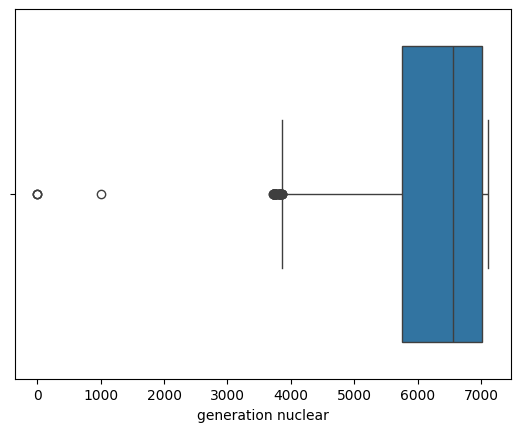

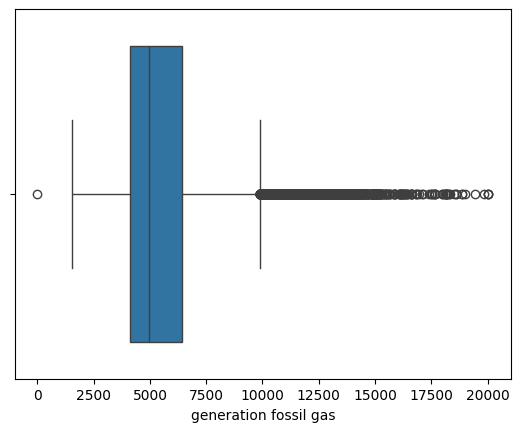

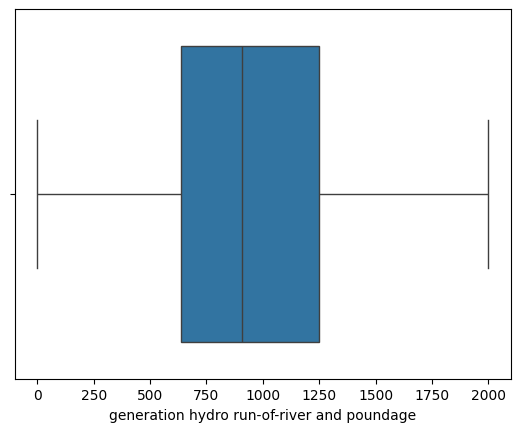

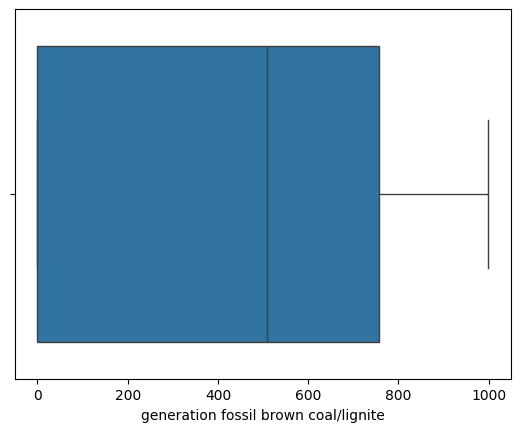

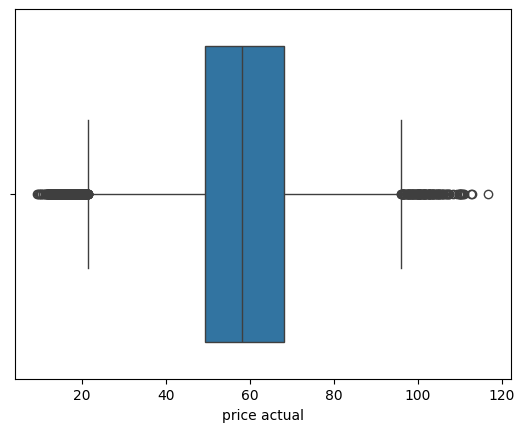

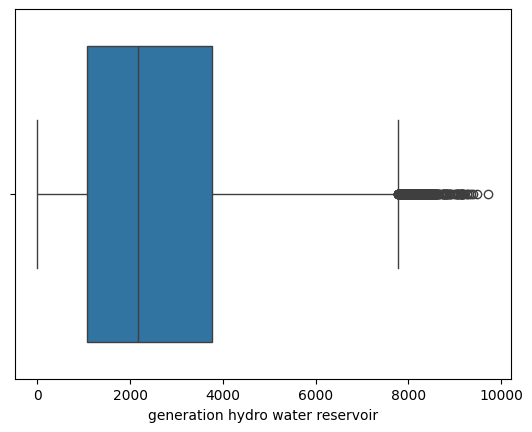

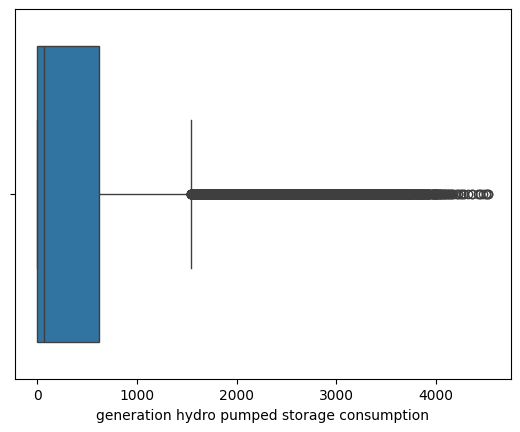

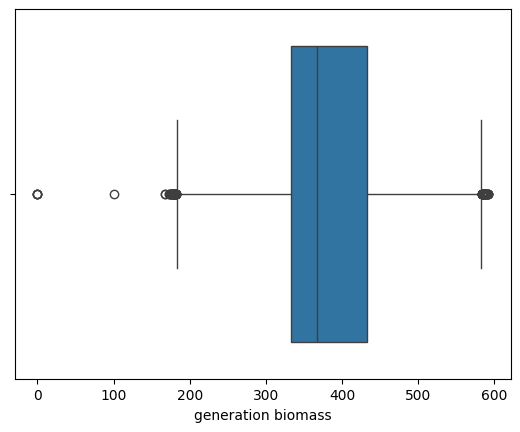

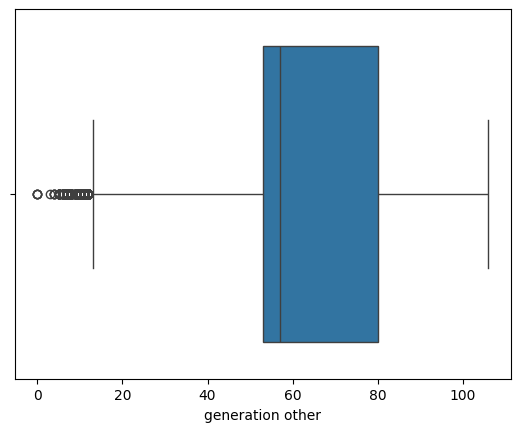

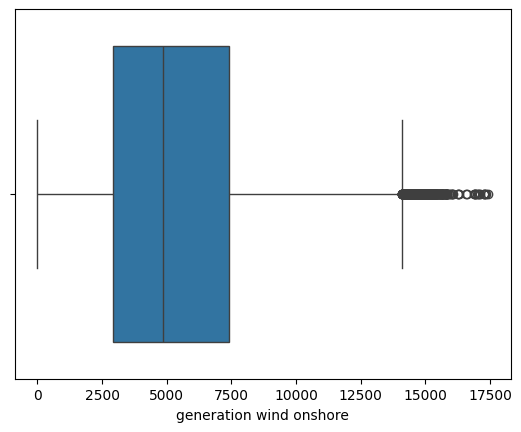

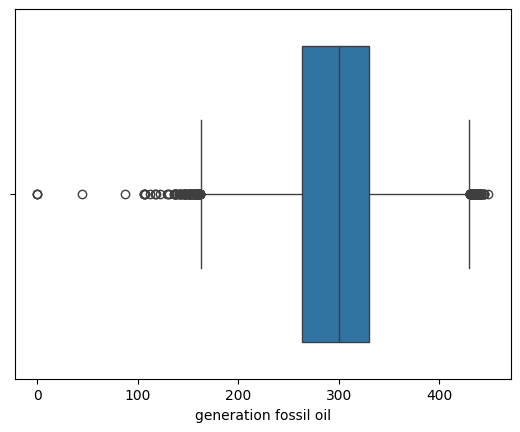

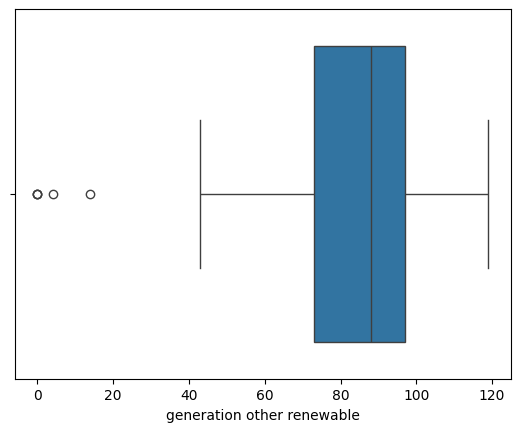

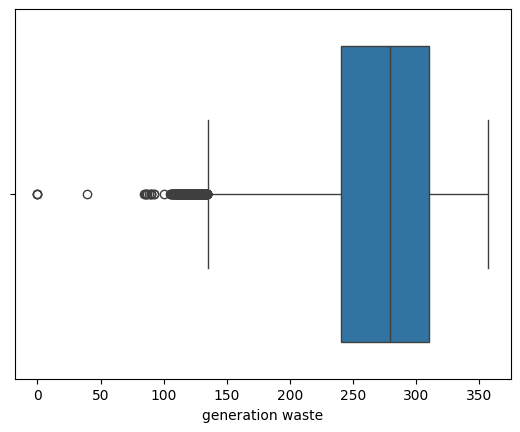

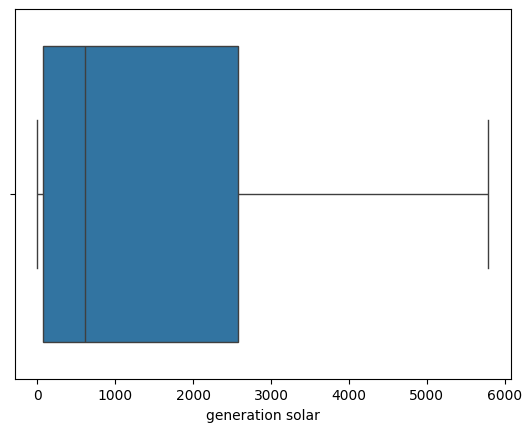

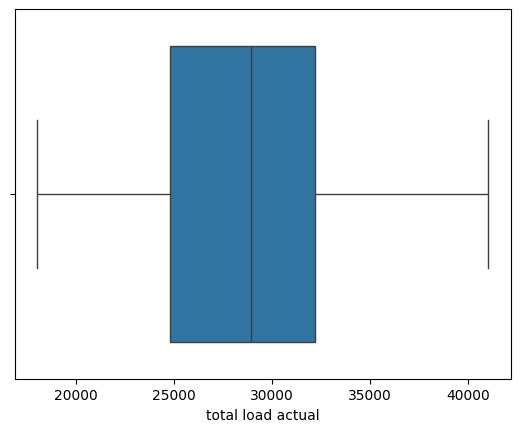

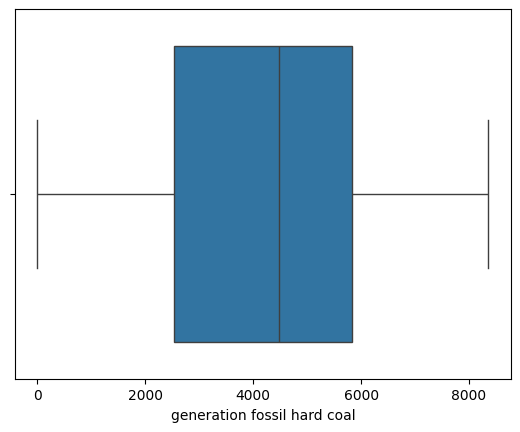

In [126]:
for i in list(set(list(energy_dataframe.columns)) - set(['time'])):
  sns.boxplot(x=energy_dataframe[i])
  plt.show()

In [127]:
weather_cities.describe()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,175320.000000,175320.000000,175320.000000,1.753200e+05,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000
mean,289.707651,288.428433,291.172255,1.070199e+03,68.032307,2.470009,166.724909,0.069308,0.000386,0.004846,24.344057,763.452390
std,8.024910,7.948249,8.613916,6.021769e+03,21.838097,2.095140,116.548788,0.385915,0.007348,0.224547,30.339522,103.125539
min,262.240000,262.240000,262.240000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000
25%,283.830000,282.784586,284.909258,1.013000e+03,53.000000,1.000000,56.000000,0.000000,0.000000,0.000000,0.000000,800.000000
50%,289.150000,288.150000,290.150000,1.018000e+03,72.000000,2.000000,178.000000,0.000000,0.000000,0.000000,16.000000,800.000000
75%,295.240000,294.150000,297.150000,1.022000e+03,87.000000,4.000000,270.000000,0.000000,0.000000,0.000000,40.000000,801.000000
max,315.600000,315.150000,321.150000,1.008371e+06,100.000000,133.000000,360.000000,12.000000,2.315000,21.500000,100.000000,804.000000


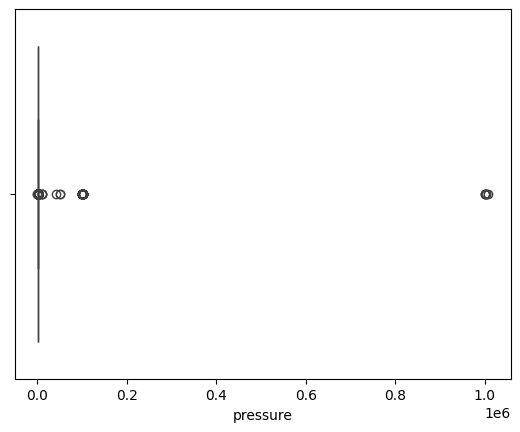

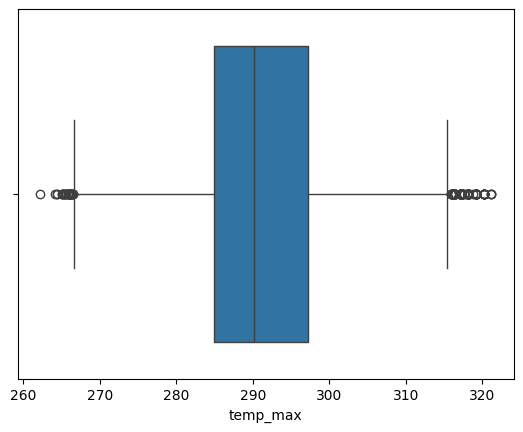

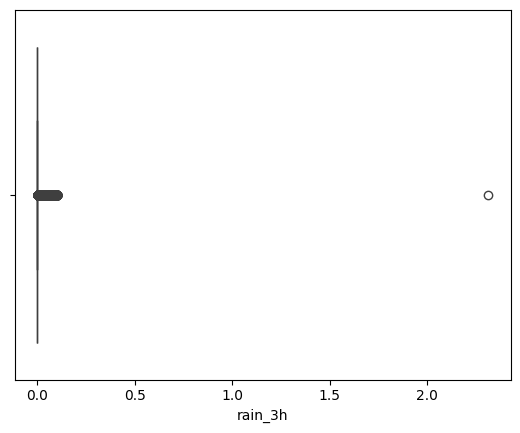

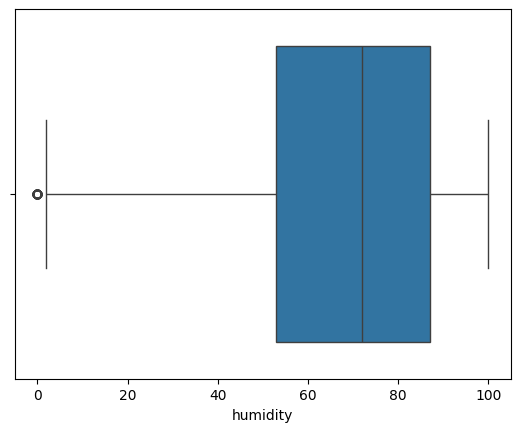

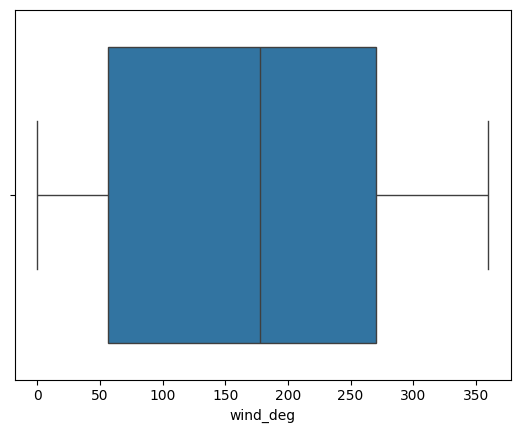

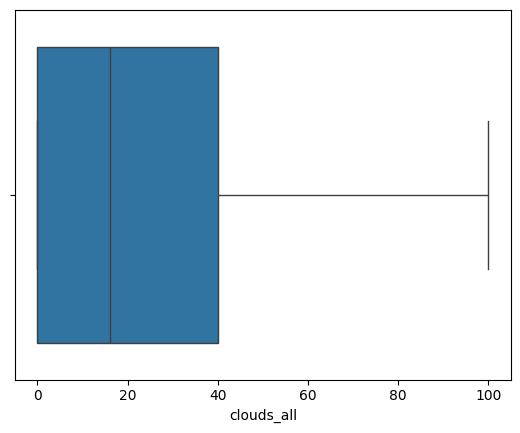

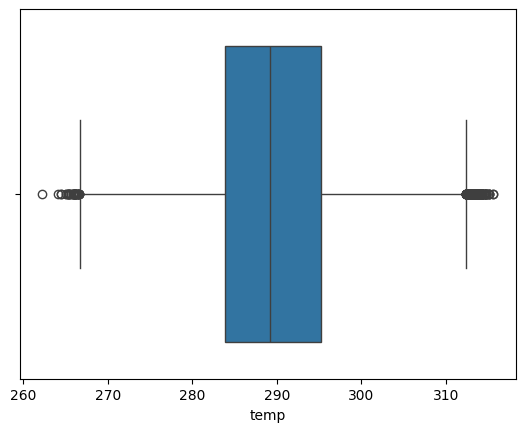

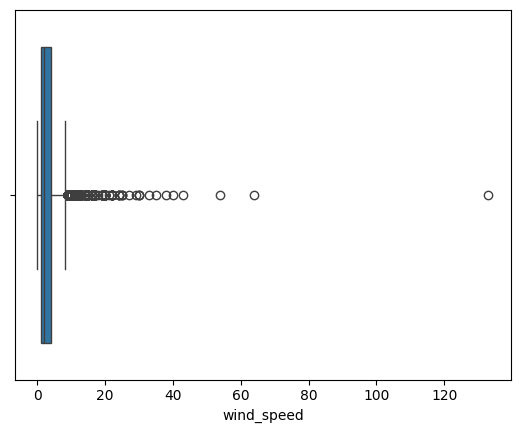

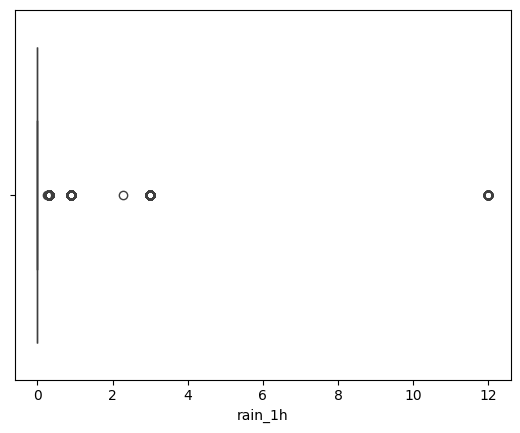

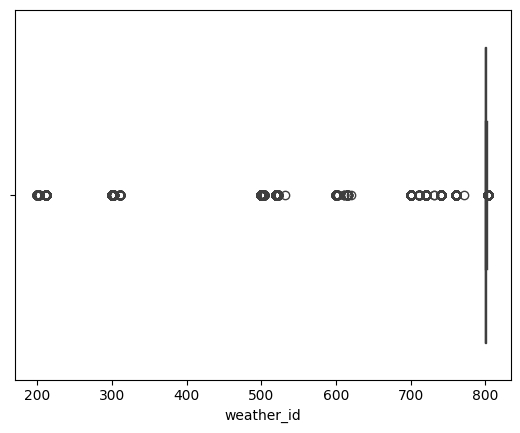

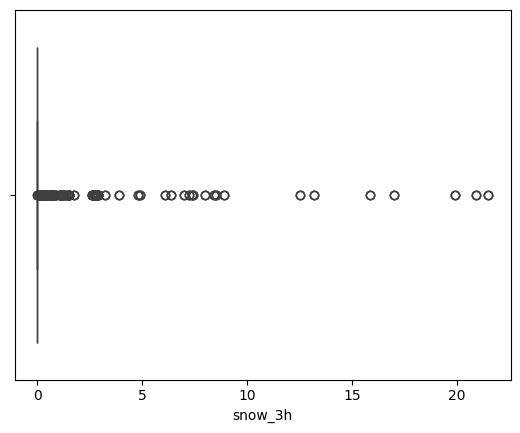

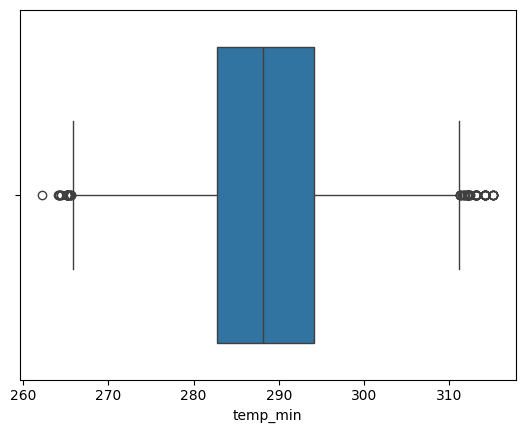

In [128]:
numerical_weather_columns = list(set(list(weather_cities.columns)) - set(['dt_iso', 'city_name', 'weather_main', 'weather_description', 'weather_icon']))

for i in numerical_weather_columns:
  sns.boxplot(x = weather_cities[i])
  plt.show()

**Observation:**
<ul>
<li>We can see that the columns 'wind_speed' and 'pressure' may have outliers.

In [129]:
# Replace outliers in 'pressure' with NaNs

weather_cities.loc[weather_cities.pressure > 1040, 'pressure'] = np.nan
weather_cities.loc[weather_cities.pressure < 960, 'pressure'] = np.nan

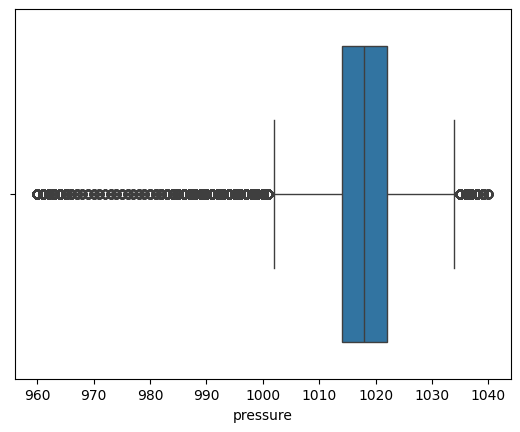

In [130]:
sns.boxplot(x = weather_cities['pressure'])
plt.show()

In [131]:
# Replace outliers in 'wind_speed' with NaNs

weather_cities.loc[weather_cities.wind_speed > 70, 'wind_speed'] = np.nan

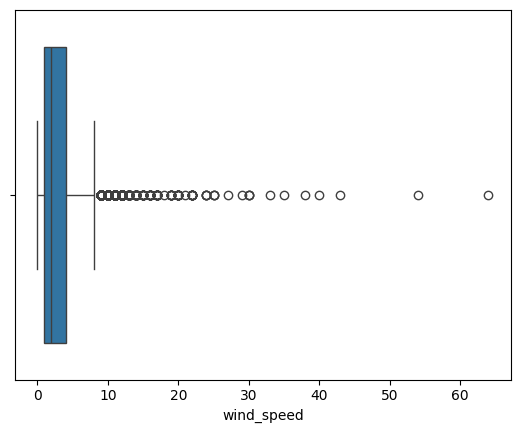

In [132]:
sns.boxplot(x = weather_cities['wind_speed'])
plt.show()

In [133]:
# Imputing the Nan values

weather_cities.interpolate(method='linear', limit_direction='both', inplace=True, axis=0)

## 6. Modifying the weather dataset according to the cities

In [134]:
weather_data = weather_cities[['weather_main', 'weather_id', 'weather_description', 'weather_icon']]
weather_data.head()

,weather_main,weather_id,weather_description,weather_icon
0,clear,800,sky is clear,01n
1,clear,800,sky is clear,01n
2,clear,800,sky is clear,01n
3,clear,800,sky is clear,01n
4,clear,800,sky is clear,01n


In [135]:
categorical_features = identify_nominal_columns(weather_data)
categorical_features

['weather_main', 'weather_description', 'weather_icon']

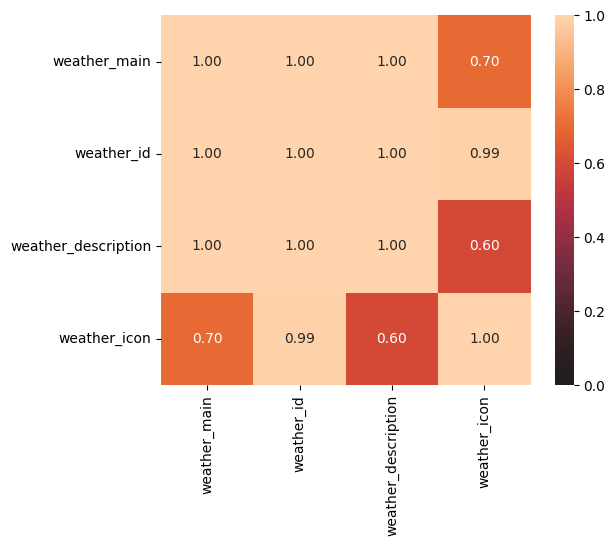

{'corr':                      weather_main  weather_id  weather_description  \
 weather_main             1.000000    0.999830             0.999917   
 weather_id               0.999830    1.000000             1.000000   
 weather_description      0.999917    1.000000             1.000000   
 weather_icon             0.699959    0.991071             0.599294   
 
                      weather_icon  
 weather_main             0.699959  
 weather_id               0.991071  
 weather_description      0.599294  
 weather_icon             1.000000  ,
 'ax': <Axes: >}

In [136]:
associations(weather_data, nominal_columns='auto', numerical_columns=None, mark_columns=False, nom_nom_assoc='cramer', num_num_assoc='pearson', ax=None, figsize=None, annot=True, fmt='.2f', cmap=None, sv_color='silver', cbar=True, vmax=1.0, vmin=None, plot=True, compute_only=False, clustering=False, title=None, filename=None)

**Observation:**
<ol>
<li>We can observe that there is high correlation among all the columns of the weather data.
<li>Hence we can take weather id and drop all others columns.
</ol>

In [137]:
weather_cities = weather_cities.drop(columns = ['weather_main', 'weather_description', 'weather_icon'], axis=1)

weather_cities_city_name = weather_cities.groupby('city_name')
weather_Valencia = weather_cities_city_name.get_group('Valencia')
weather_Valencia = weather_Valencia.add_prefix('Valencia_')
weather_Madrid = weather_cities_city_name.get_group('Madrid')
weather_Madrid = weather_Madrid.add_prefix('Madrid_')
weather_Bilbao = weather_cities_city_name.get_group('Bilbao')
weather_Bilbao = weather_Bilbao.add_prefix('Bilbao_')
weather_Barcelona = weather_cities_city_name.get_group(' Barcelona')
weather_Barcelona = weather_Barcelona.add_prefix('Barcelona_')
weather_Seville = weather_cities_city_name.get_group('Seville')
weather_Seville = weather_Seville.add_prefix('Seville_')

In [138]:
weather_Valencia.rename(columns = {'Valencia_dt_iso':'time'}, inplace = True)
weather_Madrid.rename(columns = {'Madrid_dt_iso':'time'}, inplace = True)
weather_Bilbao.rename(columns = {'Bilbao_dt_iso':'time'}, inplace = True)
weather_Barcelona.rename(columns = {'Barcelona_dt_iso':'time'}, inplace = True)
weather_Seville.rename(columns = {'Seville_dt_iso':'time'}, inplace = True)

In [139]:
df_merged = weather_Valencia.merge(weather_Madrid, on = 'time').merge(weather_Bilbao, on = 'time').merge(weather_Barcelona, on = 'time').merge(weather_Seville, on = 'time')
df_merged.head()

,time,Valencia_city_name,Valencia_temp,Valencia_temp_min,Valencia_temp_max,Valencia_pressure,Valencia_humidity,Valencia_wind_speed,Valencia_wind_deg,Valencia_rain_1h,Valencia_rain_3h,Valencia_snow_3h,Valencia_clouds_all,Valencia_weather_id,Madrid_city_name,Madrid_temp,Madrid_temp_min,Madrid_temp_max,Madrid_pressure,Madrid_humidity,Madrid_wind_speed,Madrid_wind_deg,Madrid_rain_1h,Madrid_rain_3h,Madrid_snow_3h,Madrid_clouds_all,Madrid_weather_id,Bilbao_city_name,Bilbao_temp,Bilbao_temp_min,Bilbao_temp_max,Bilbao_pressure,Bilbao_humidity,Bilbao_wind_speed,Bilbao_wind_deg,Bilbao_rain_1h,Bilbao_rain_3h,Bilbao_snow_3h,Bilbao_clouds_all,Bilbao_weather_id,Barcelona_city_name,Barcelona_temp,Barcelona_temp_min,Barcelona_temp_max,Barcelona_pressure,Barcelona_humidity,Barcelona_wind_speed,Barcelona_wind_deg,Barcelona_rain_1h,Barcelona_rain_3h,Barcelona_snow_3h,Barcelona_clouds_all,Barcelona_weather_id,Seville_city_name,Seville_temp,Seville_temp_min,Seville_temp_max,Seville_pressure,Seville_humidity,Seville_wind_speed,Seville_wind_deg,Seville_rain_1h,Seville_rain_3h,Seville_snow_3h,Seville_clouds_all,Seville_weather_id
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001.0,77,1.0,62,0.0,0.0,0.0,0,800,Madrid,267.325,267.325,267.325,971.0,63,1.0,309,0.0,0.0,0.0,0,800,Bilbao,269.657312,269.657312,269.657312,1036.0,97,0.0,226,0.0,0.0,0.0,0,800,Barcelona,281.625,281.625,281.625,1035.0,100,7.0,58,0.0,0.0,0.0,0,800,Seville,273.375,273.375,273.375,1039.0,75,1.0,21,0.0,0.0,0.0,0,800
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001.0,77,1.0,62,0.0,0.0,0.0,0,800,Madrid,267.325,267.325,267.325,971.0,63,1.0,309,0.0,0.0,0.0,0,800,Bilbao,269.763500,269.763500,269.763500,1035.0,97,0.0,229,0.0,0.0,0.0,0,800,Barcelona,281.625,281.625,281.625,1035.0,100,7.0,58,0.0,0.0,0.0,0,800,Seville,273.375,273.375,273.375,1039.0,75,1.0,21,0.0,0.0,0.0,0,800
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002.0,78,0.0,23,0.0,0.0,0.0,0,800,Madrid,266.186,266.186,266.186,971.0,64,1.0,273,0.0,0.0,0.0,0,800,Bilbao,269.251688,269.251688,269.251688,1036.0,97,1.0,224,0.0,0.0,0.0,0,800,Barcelona,281.286,281.286,281.286,1036.0,100,7.0,48,0.0,0.0,0.0,0,800,Seville,274.086,274.086,274.086,1039.0,71,3.0,27,0.0,0.0,0.0,0,800
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002.0,78,0.0,23,0.0,0.0,0.0,0,800,Madrid,266.186,266.186,266.186,971.0,64,1.0,273,0.0,0.0,0.0,0,800,Bilbao,269.203344,269.203344,269.203344,1035.0,97,1.0,225,0.0,0.0,0.0,0,800,Barcelona,281.286,281.286,281.286,1036.0,100,7.0,48,0.0,0.0,0.0,0,800,Seville,274.086,274.086,274.086,1039.0,71,3.0,27,0.0,0.0,0.0,0,800
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002.0,78,0.0,23,0.0,0.0,0.0,0,800,Madrid,266.186,266.186,266.186,971.0,64,1.0,273,0.0,0.0,0.0,0,800,Bilbao,269.485500,269.485500,269.485500,1035.0,97,1.0,221,0.0,0.0,0.0,0,800,Barcelona,281.286,281.286,281.286,1036.0,100,7.0,48,0.0,0.0,0.0,0,800,Seville,274.086,274.086,274.086,1039.0,71,3.0,27,0.0,0.0,0.0,0,800


In [140]:
df_merged = df_merged.drop(columns = ['Valencia_city_name', 'Madrid_city_name', 'Bilbao_city_name', 'Barcelona_city_name', 'Seville_city_name'], axis = 1)
df_merged.head()


,time,Valencia_temp,Valencia_temp_min,Valencia_temp_max,Valencia_pressure,Valencia_humidity,Valencia_wind_speed,Valencia_wind_deg,Valencia_rain_1h,Valencia_rain_3h,Valencia_snow_3h,Valencia_clouds_all,Valencia_weather_id,Madrid_temp,Madrid_temp_min,Madrid_temp_max,Madrid_pressure,Madrid_humidity,Madrid_wind_speed,Madrid_wind_deg,Madrid_rain_1h,Madrid_rain_3h,Madrid_snow_3h,Madrid_clouds_all,Madrid_weather_id,Bilbao_temp,Bilbao_temp_min,Bilbao_temp_max,Bilbao_pressure,Bilbao_humidity,Bilbao_wind_speed,Bilbao_wind_deg,Bilbao_rain_1h,Bilbao_rain_3h,Bilbao_snow_3h,Bilbao_clouds_all,Bilbao_weather_id,Barcelona_temp,Barcelona_temp_min,Barcelona_temp_max,Barcelona_pressure,Barcelona_humidity,Barcelona_wind_speed,Barcelona_wind_deg,Barcelona_rain_1h,Barcelona_rain_3h,Barcelona_snow_3h,Barcelona_clouds_all,Barcelona_weather_id,Seville_temp,Seville_temp_min,Seville_temp_max,Seville_pressure,Seville_humidity,Seville_wind_speed,Seville_wind_deg,Seville_rain_1h,Seville_rain_3h,Seville_snow_3h,Seville_clouds_all,Seville_weather_id
0,2015-01-01 00:00:00+01:00,270.475,270.475,270.475,1001.0,77,1.0,62,0.0,0.0,0.0,0,800,267.325,267.325,267.325,971.0,63,1.0,309,0.0,0.0,0.0,0,800,269.657312,269.657312,269.657312,1036.0,97,0.0,226,0.0,0.0,0.0,0,800,281.625,281.625,281.625,1035.0,100,7.0,58,0.0,0.0,0.0,0,800,273.375,273.375,273.375,1039.0,75,1.0,21,0.0,0.0,0.0,0,800
1,2015-01-01 01:00:00+01:00,270.475,270.475,270.475,1001.0,77,1.0,62,0.0,0.0,0.0,0,800,267.325,267.325,267.325,971.0,63,1.0,309,0.0,0.0,0.0,0,800,269.763500,269.763500,269.763500,1035.0,97,0.0,229,0.0,0.0,0.0,0,800,281.625,281.625,281.625,1035.0,100,7.0,58,0.0,0.0,0.0,0,800,273.375,273.375,273.375,1039.0,75,1.0,21,0.0,0.0,0.0,0,800
2,2015-01-01 02:00:00+01:00,269.686,269.686,269.686,1002.0,78,0.0,23,0.0,0.0,0.0,0,800,266.186,266.186,266.186,971.0,64,1.0,273,0.0,0.0,0.0,0,800,269.251688,269.251688,269.251688,1036.0,97,1.0,224,0.0,0.0,0.0,0,800,281.286,281.286,281.286,1036.0,100,7.0,48,0.0,0.0,0.0,0,800,274.086,274.086,274.086,1039.0,71,3.0,27,0.0,0.0,0.0,0,800
3,2015-01-01 03:00:00+01:00,269.686,269.686,269.686,1002.0,78,0.0,23,0.0,0.0,0.0,0,800,266.186,266.186,266.186,971.0,64,1.0,273,0.0,0.0,0.0,0,800,269.203344,269.203344,269.203344,1035.0,97,1.0,225,0.0,0.0,0.0,0,800,281.286,281.286,281.286,1036.0,100,7.0,48,0.0,0.0,0.0,0,800,274.086,274.086,274.086,1039.0,71,3.0,27,0.0,0.0,0.0,0,800
4,2015-01-01 04:00:00+01:00,269.686,269.686,269.686,1002.0,78,0.0,23,0.0,0.0,0.0,0,800,266.186,266.186,266.186,971.0,64,1.0,273,0.0,0.0,0.0,0,800,269.485500,269.485500,269.485500,1035.0,97,1.0,221,0.0,0.0,0.0,0,800,281.286,281.286,281.286,1036.0,100,7.0,48,0.0,0.0,0.0,0,800,274.086,274.086,274.086,1039.0,71,3.0,27,0.0,0.0,0.0,0,800


In [141]:
df_merged = df_merged.merge(energy_dataframe, on = 'time')
df_merged.head()

,time,Valencia_temp,Valencia_temp_min,Valencia_temp_max,Valencia_pressure,Valencia_humidity,Valencia_wind_speed,Valencia_wind_deg,Valencia_rain_1h,Valencia_rain_3h,Valencia_snow_3h,Valencia_clouds_all,Valencia_weather_id,Madrid_temp,Madrid_temp_min,Madrid_temp_max,Madrid_pressure,Madrid_humidity,Madrid_wind_speed,Madrid_wind_deg,Madrid_rain_1h,Madrid_rain_3h,Madrid_snow_3h,Madrid_clouds_all,Madrid_weather_id,Bilbao_temp,Bilbao_temp_min,Bilbao_temp_max,Bilbao_pressure,Bilbao_humidity,Bilbao_wind_speed,Bilbao_wind_deg,Bilbao_rain_1h,Bilbao_rain_3h,Bilbao_snow_3h,Bilbao_clouds_all,Bilbao_weather_id,Barcelona_temp,Barcelona_temp_min,Barcelona_temp_max,Barcelona_pressure,Barcelona_humidity,Barcelona_wind_speed,Barcelona_wind_deg,Barcelona_rain_1h,Barcelona_rain_3h,Barcelona_snow_3h,Barcelona_clouds_all,Barcelona_weather_id,Seville_temp,Seville_temp_min,Seville_temp_max,Seville_pressure,Seville_humidity,Seville_wind_speed,Seville_wind_deg,Seville_rain_1h,Seville_rain_3h,Seville_snow_3h,Seville_clouds_all,Seville_weather_id,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price actual
0,2015-01-01 00:00:00+01:00,270.475,270.475,270.475,1001.0,77,1.0,62,0.0,0.0,0.0,0,800,267.325,267.325,267.325,971.0,63,1.0,309,0.0,0.0,0.0,0,800,269.657312,269.657312,269.657312,1036.0,97,0.0,226,0.0,0.0,0.0,0,800,281.625,281.625,281.625,1035.0,100,7.0,58,0.0,0.0,0.0,0,800,273.375,273.375,273.375,1039.0,75,1.0,21,0.0,0.0,0.0,0,800,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,25385.0,65.41
1,2015-01-01 01:00:00+01:00,270.475,270.475,270.475,1001.0,77,1.0,62,0.0,0.0,0.0,0,800,267.325,267.325,267.325,971.0,63,1.0,309,0.0,0.0,0.0,0,800,269.763500,269.763500,269.763500,1035.0,97,0.0,229,0.0,0.0,0.0,0,800,281.625,281.625,281.625,1035.0,100,7.0,58,0.0,0.0,0.0,0,800,273.375,273.375,273.375,1039.0,75,1.0,21,0.0,0.0,0.0,0,800,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,24382.0,64.92
2,2015-01-01 02:00:00+01:00,269.686,269.686,269.686,1002.0,78,0.0,23,0.0,0.0,0.0,0,800,266.186,266.186,266.186,971.0,64,1.0,273,0.0,0.0,0.0,0,800,269.251688,269.251688,269.251688,1036.0,97,1.0,224,0.0,0.0,0.0,0,800,281.286,281.286,281.286,1036.0,100,7.0,48,0.0,0.0,0.0,0,800,274.086,274.086,274.086,1039.0,71,3.0,27,0.0,0.0,0.0,0,800,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,22734.0,64.48
3,2015-01-01 03:00:00+01:00,269.686,269.686,269.686,1002.0,78,0.0,23,0.0,0.0,0.0,0,800,266.186,266.186,266.186,971.0,64,1.0,273,0.0,0.0,0.0,0,800,269.203344,269.203344,269.203344,1035.0,97,1.0,225,0.0,0.0,0.0,0,800,281.286,281.286,281.286,1036.0,100,7.0,48,0.0,0.0,0.0,0,800,274.086,274.086,274.086,1039.0,71,3.0,27,0.0,0.0,0.0,0,800,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,21286.0,59.32
4,2015-01-01 04:00:00+01:00,269.686,269.686,269.686,1002.0,78,0.0,23,0.0,0.0,0.0,0,800,266.186,266.186,266.186,971.0,64,1.0,273,0.0,0.0,0.0,0,800,269.485500,269.485500,269.485500,1035.0,97,1.0,221,0.0,0.0,0.0,0,800,281.286,281.286,281.286,1036.0,100,7.0,48,0.0,0.0,0.0,0,800,274.086,274.086,274.086,1039.0,71,3.0,27,0.0,0.0,0.0,0,800,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,20264.0,56.04


<Axes: >

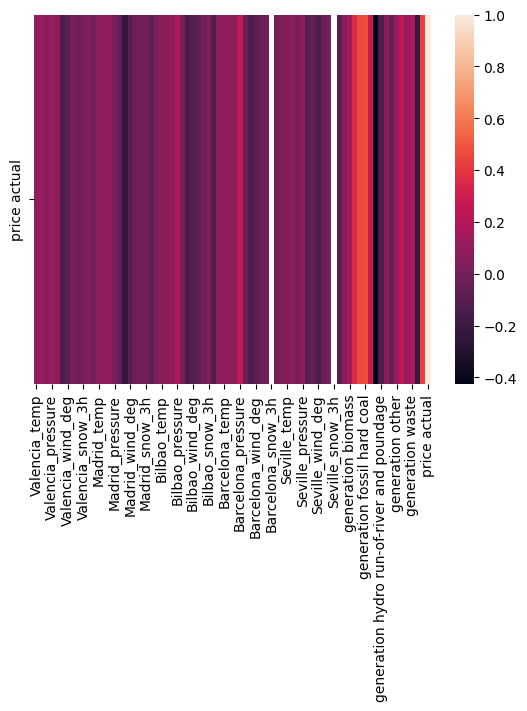

In [142]:
df_merged_correlation = df_merged.drop(columns = ['time'])

sns.heatmap(df_merged_correlation.corr().loc[['price actual'],:])

In [143]:
corr = pd.DataFrame(df_merged_correlation.corrwith(df_merged_correlation['price actual']))
pd.set_option('display.max_rows', None)
print(corr)

                                                    0
Valencia_temp                                0.090505
Valencia_temp_min                            0.133141
Valencia_temp_max                            0.047478
Valencia_pressure                            0.109770
Valencia_humidity                            0.078819
Valencia_wind_speed                         -0.140678
Valencia_wind_deg                           -0.092710
Valencia_rain_1h                             0.012049
Valencia_rain_3h                            -0.024581
Valencia_snow_3h                             0.007461
Valencia_clouds_all                          0.040055
Valencia_weather_id                         -0.023139
Madrid_temp                                  0.087995
Madrid_temp_min                              0.066777
Madrid_temp_max                              0.096279
Madrid_pressure                              0.024266
Madrid_humidity                             -0.064668
Madrid_wind_speed           

In [144]:
df_merged = df_merged.drop(columns = ['Seville_snow_3h', 'Barcelona_snow_3h'])

## 7. Model selection and training and evaluating

In [145]:
df_merged = df_merged.drop(columns = ['time'])

In [146]:
X = df_merged[df_merged.columns.drop('price actual')]
y = df_merged['price actual']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(23492, 73)
(11572, 73)
(23492,)
(11572,)


In [147]:
# initialize Our first XGBoost model...
clf_xgb = xgb.XGBRegressor(n_estimators = 500, max_depth = 10, learning_rate = 0.1, booster = 'gbtree')
clf_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [148]:
# Predict on test data
y_pred_xgb = clf_xgb.predict(X_test)

In [149]:
# RMSE Computation
rmse = np.sqrt(MSE(y_test, y_pred_xgb))
print("RMSE : % f" %(rmse))

RMSE :  4.488275


In [150]:
y_test.index

Int64Index([ 6070, 32600,  8846,  1483,  4219,  7289, 12994,  9026, 23516,
            32732,
            ...
            13153, 32187, 10802, 29645,   115, 20299, 23934, 27963, 11562,
            14750],
           dtype='int64', length=11572)

In [153]:
y_test_values = y_test.values
y_test_values

array([65.66, 81.89, 49.84, ..., 13.44, 39.91, 56.47])

In [154]:
y_pred_xgb

array([62.16303 , 82.938484, 48.04005 , ..., 25.616323, 37.885113,
       61.36449 ], dtype=float32)

In [155]:
forecast_data.head()

,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,price day ahead
0,17.0,6436.0,26118.0,50.10
1,16.0,5856.0,24934.0,48.10
2,8.0,5454.0,23515.0,47.33
3,2.0,5151.0,22642.0,42.27
4,9.0,4861.0,21785.0,38.41


In [156]:
forecast_data['price day ahead'].index.isin([y_test.index])

array([False, False, False, ..., False, False, False])

In [157]:
selected_forecast_data = forecast_data.loc[y_test.index, 'price day ahead']
selected_forecast_data = selected_forecast_data.values

In [159]:
selected_forecast_data

array([52.62, 76.3 , 33.45, ..., 52.12, 31.11, 43.42])

In [161]:
# RMSE Computation
rmse = np.sqrt(MSE(y, forecast_data['price day ahead']))
print("RMSE : % f" %(rmse))

RMSE :  13.249857


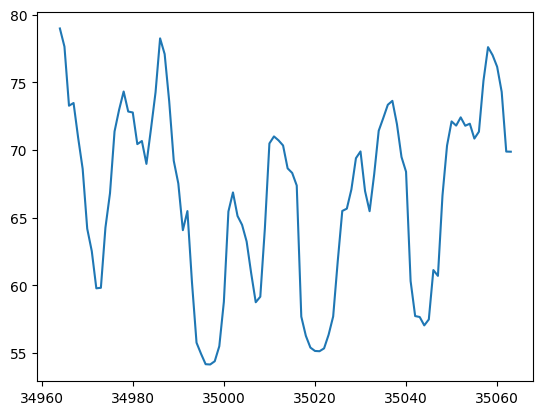

In [162]:
plt.plot(energy_dataframe['price actual'][-100:], label = "Price Actual")

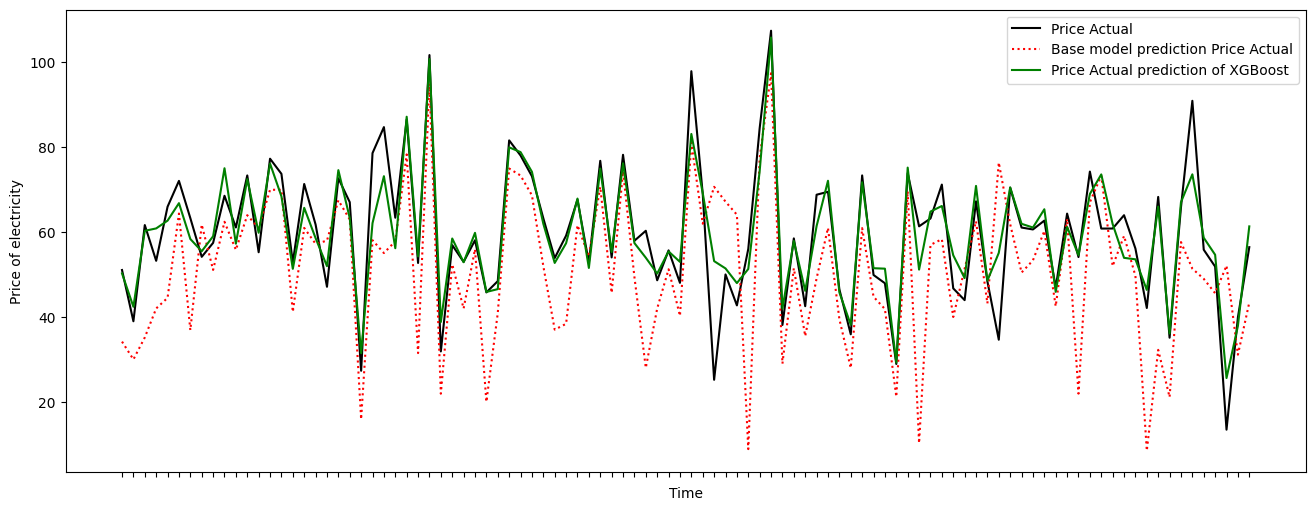

In [163]:
plt.figure(figsize=(16, 6))
plt.plot(y_test_values[-100:], label = "Price Actual", color = 'black')
plt.plot(selected_forecast_data[-100:], linestyle='dotted', label = "Base model prediction Price Actual", color = 'red')
plt.plot(y_pred_xgb[-100:], label = "Price Actual prediction of XGBoost", color = 'green')

x_ticks = range(len(y_test_values[-100:]))
plt.xticks(x_ticks, [''] * len(x_ticks))  # Empty labels for x-axis
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price of electricity')
plt.show()

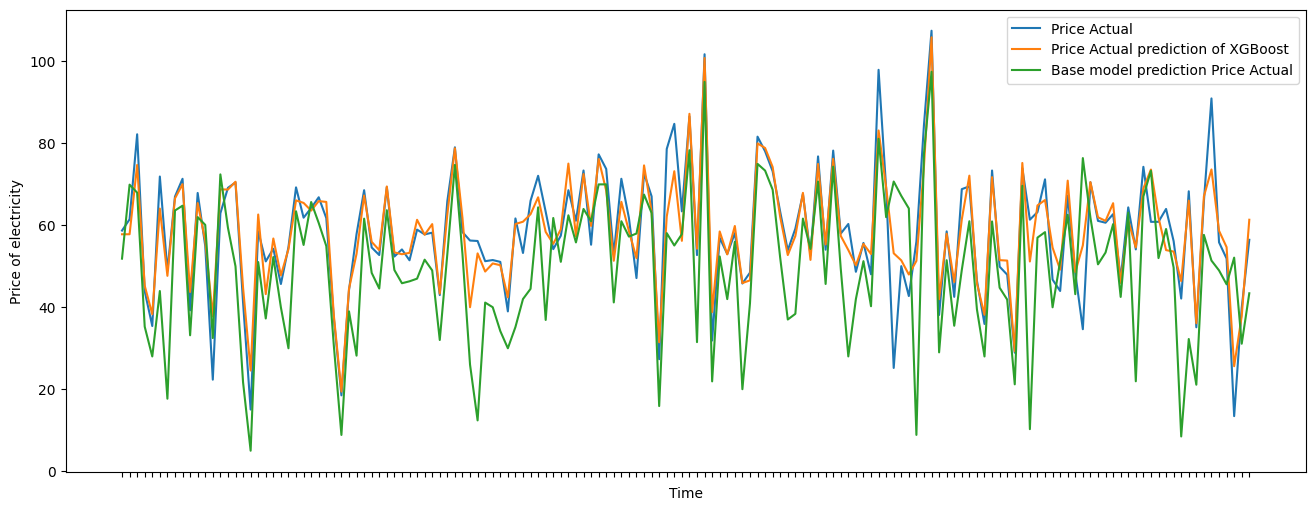

In [164]:
plt.figure(figsize=(16, 6))
plt.plot(y_test_values[-150:], label = "Price Actual")
plt.plot(y_pred_xgb[-150:], label = "Price Actual prediction of XGBoost")
plt.plot(selected_forecast_data[-150:], label = "Base model prediction Price Actual")
x_ticks = range(len(y_test_values[-150:]))
# Set custom x-axis tick labels
plt.xticks(x_ticks, [''] * len(x_ticks))  # Empty labels for x-axis
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price of electricity')
plt.show()

In [53]:
y_pred_xgb = clf_xgb.predict(X)

# RMSE Computation
rmse = np.sqrt(MSE(y, y_pred_xgb))
print("RMSE : % f" %(rmse))

RMSE :  2.581796


**Observation:**

<ol>
<li>The root mean sqaure error for the predicted value on test data is found to be 4.48.
<li>The RMS value for the baseline model is found 13.249857.
<li>The RMS value for the our model is found 2.58.
<li>So there is improvemenet above the baseline model from 13.249 to 2.58.
<li>We can say that there is 80.5% improvement from the base model to my trained model.